In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import urllib.request
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [31]:
#root_name = 'GaiaSource_003112-005263.csv'
#name = root_name + '.gz'
#fn = 'http://cdn.gea.esac.esa.int/Gaia/gedr3/gaia_source/'+name
#executable = 'wget --directory-prefix=data/GaiaSource/ '+fn
#os.system(executable)
#!wget -r -np -nH --show-progress --cut-dirs=3 -P data/GaiaSource http://cdn.gea.esac.esa.int/Gaia/gedr3/gaia_source
#!gzip -d data/GaiaSource/*

In [32]:
import pandas as pd
import glob
import os
#all_files = glob.glob('data/GaiaSource/*.csv')
all_files = [ 'processed.csv']
data = pd.concat(map(pd.read_csv, all_files)) #('data/GaiaSource/'+root_name)
pd.Index(['ra', 'dec', 'phot_g_mean_mag', 'parallax', 'parallax_over_error', 'bp_rp'], dtype='object')
#pd.Index(['solution_id', 'source_id', 'random_index', 'ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr',
#       'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr', 'astrometric_n_obs_al', 'astrometric_n_obs_ac',
#       'astrometric_n_good_obs_al', 'astrometric_n_good_obs_ac', 'astrometric_n_bad_obs_al', 'astrometric_n_bad_obs_ac', 'astrometric_delta_q', 'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'astrometric_primary_flag',
#       'astrometric_relegation_factor', 'astrometric_weight_al', 'astrometric_weight_ac', 'astrometric_priors_used', 'matched_observations', 'duplicated_source', 'scan_direction_strength_k1', 'scan_direction_strength_k2',
#       'scan_direction_strength_k3', 'scan_direction_strength_k4', 'scan_direction_mean_k1', 'scan_direction_mean_k2', 'scan_direction_mean_k3', 'scan_direction_mean_k4', 'phot_g_n_obs', 'phot_g_mean_flux', 'phot_g_mean_flux_error', 'phot_g_mean_mag',
#       'phot_variable_flag', 'l', 'b', 'ecl_lon', 'ecl_lat'],
#      dtype='object')

Index(['ra', 'dec', 'phot_g_mean_mag', 'parallax', 'parallax_over_error',
       'bp_rp'],
      dtype='object')

In [33]:
#data = data[['ra', 'dec', 'phot_g_mean_mag', 'parallax', 'parallax_over_error', 'bp_rp']]
#data.to_csv('processed.csv')

In [34]:
import warnings
def to_abs_mag(mag, parallax, par_error):
    mag = np.array(mag)
    par = np.array(parallax)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        distance = np.abs(1.0 / (par / 1000.0)) 
        absmag = mag + 5.0 - (5.0 * np.log10(distance))
        return absmag

# Filter out parallax errors 
data = data[data['parallax_over_error'] > 10]

# Magnitude
data['mag'] = to_abs_mag(data.phot_g_mean_mag, data.parallax, data.parallax_over_error)
data.dropna(subset=['mag'], inplace=True)

In [35]:
data = data[np.abs(1.0 / (data['parallax'] / 1000.0)) < 700]
data = data[data['parallax_over_error'] > 10]

In [36]:
from typing import Tuple
import math
def __clamp(value: float, min_val: int = 0, max_val: int = 255) -> int:
    if np.isnan(value):
        value = 0
    # use rounding to better represent values between max and min
    return int(round(max(min(value, max_val), min_val)))

#https://github.com/esemeniuc/kelvin_rgb/blob/master/kelvin_rgb/__init__.py
# see http://www.zombieprototypes.com/?p=210 for plot and calculation of coefficients
def k_to_rgb(kelvin: int) -> Tuple[int, int, int]:
    temperature = kelvin / 100.0

    if temperature < 66.0:
        red = 255
    else:
        # a + b x + c Log[x] /.
        # {a -> 351.97690566805693`,
        # b -> 0.114206453784165`,
        # c -> -40.25366309332127
        # x -> (kelvin/100) - 55}
        red = temperature - 55.0
        red = 351.97690566805693 + 0.114206453784165 * red - 40.25366309332127 * math.log(red)

    # Calculate green
    if temperature < 66.0:
        # a + b x + c Log[x] /.
        # {a -> -155.25485562709179`,
        # b -> -0.44596950469579133`,
        # c -> 104.49216199393888`,
        # x -> (kelvin/100) - 2}
        green = temperature - 2
        green = -155.25485562709179 - 0.44596950469579133 * green + 104.49216199393888 * math.log(green)
    else:
        # a + b x + c Log[x] /.
        # {a -> 325.4494125711974`,
        # b -> 0.07943456536662342`,
        # c -> -28.0852963507957`,
        # x -> (kelvin/100) - 50}
        green = temperature - 50.0
        green = 325.4494125711974 + 0.07943456536662342 * green - 28.0852963507957 * math.log(green)

    # Calculate blue
    if temperature >= 66.0:
        blue = 255
    elif temperature <= 20.0:
        blue = 0
    else:
        # a + b x + c Log[x] /.
        # {a -> -254.76935184120902`,
        # b -> 0.8274096064007395`,
        # c -> 115.67994401066147`,
        # x -> kelvin/100 - 10}
        blue = temperature - 10
        blue = -254.76935184120902 + 0.8274096064007395 * blue + 115.67994401066147 * math.log(blue)

    return [__clamp(red, 0, 255) / 255.0, __clamp(green, 0, 255) / 255.0, __clamp(blue, 0, 255) / 255.0]

def index_to_temp(index):
    return 5601 / np.power(index + .4, 2.0/3.0)

def error_adjust(color, err):
    if err > .1:
        return [0, 0, 0]
    else:
        return color

temp = data.bp_rp.apply(index_to_temp)
data['color'] = temp.apply(k_to_rgb)

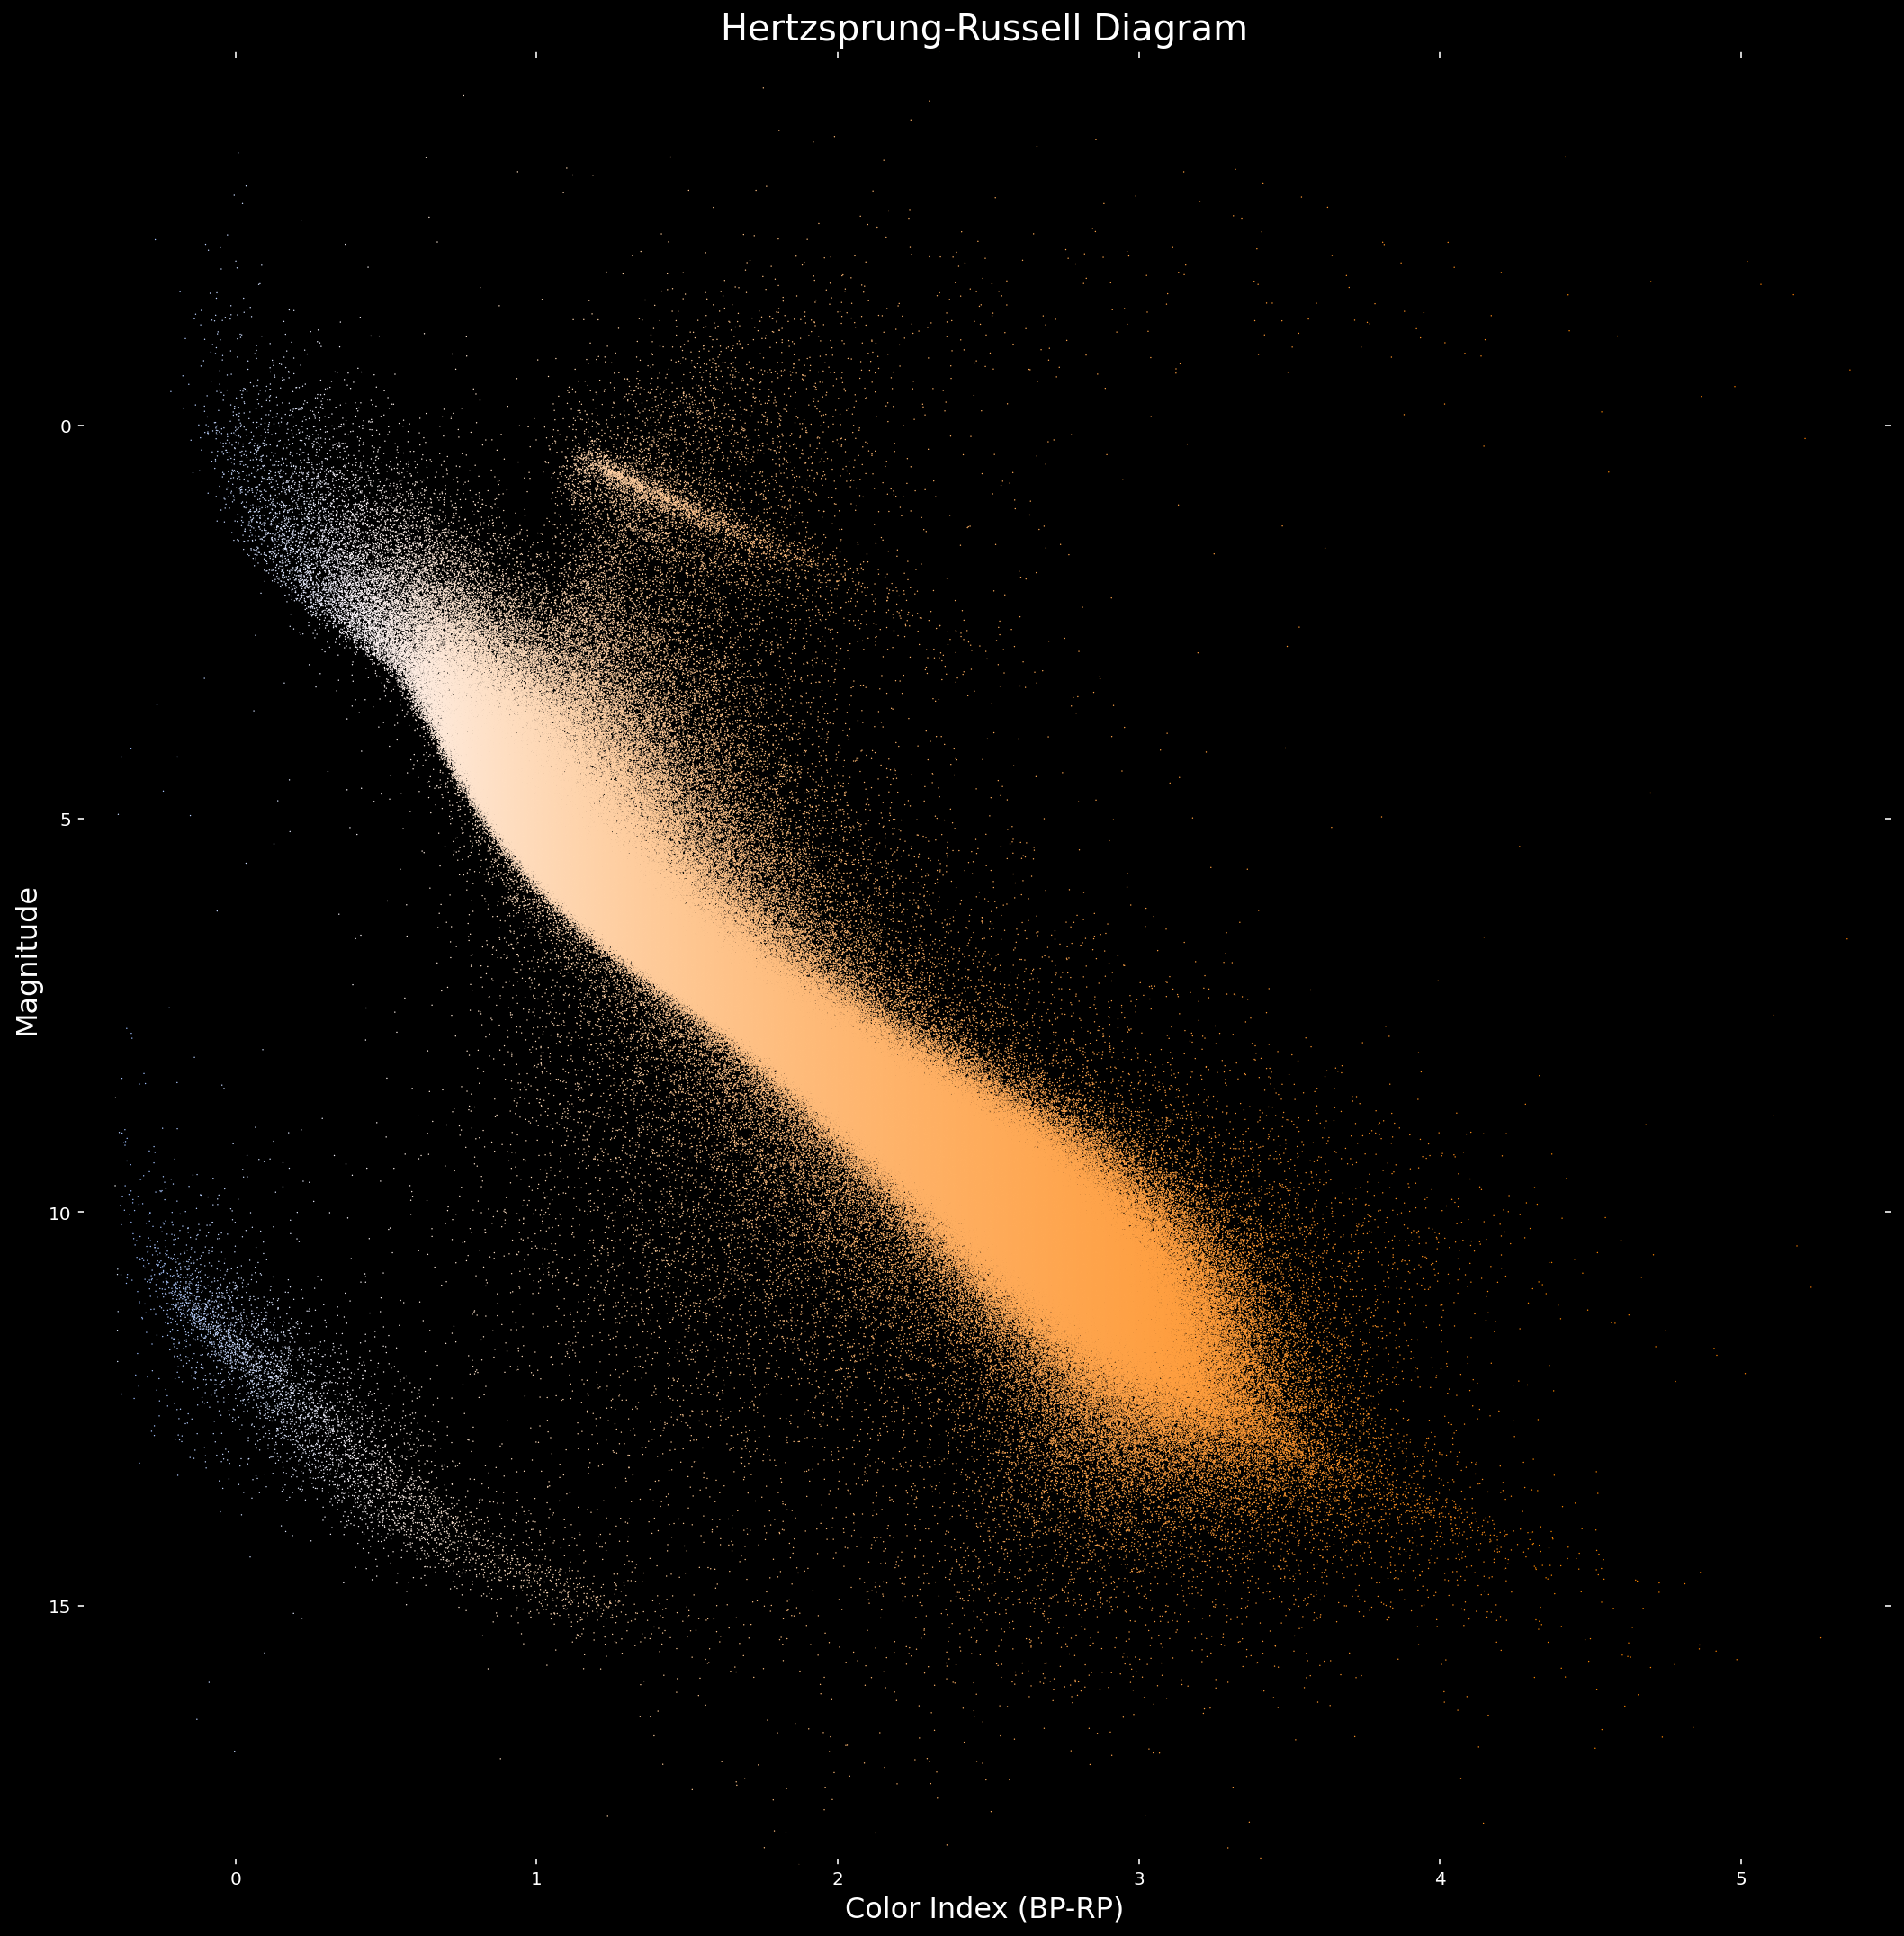

In [37]:
fig = plt.figure(
    figsize=(14, 14),
    facecolor='black'
    )
ax = fig.add_axes([1, 1, 1, 1])

ax.set_facecolor('black')
ax.set_title('Hertzsprung-Russell Diagram', color='white', fontsize=20)
ax.set_xlabel('Color Index (BP-RP)', color='white', fontsize=16)
ax.set_ylabel('Magnitude', color='white', fontsize=16)
#ax.set_xlim(-1, 6)#min(data.bp_rp), max(data.bp_rp))
#ax.set_ylim(20, -6.0)#min(data.mag))
ax.set_xlim(min(data.bp_rp), 5.5)#max(data.bp_rp))
ax.set_ylim(max(data.mag), min(data.mag))
ax.tick_params(top='off', right='off', direction='in', colors='white')

ax.scatter( data.bp_rp, data.mag,
    marker='.',
    s=2.0,
    alpha=1.0,
    facecolors=data['color'],#'white',
    linewidth=0)

#plt.savefig("Hertzsprung-Russell_Gaia.png", facecolor='white', edgecolor='black')